In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from cymr import models
from cymr import network
from cymr import fit
from cfr import framework
from psifr import fr

model_dir = '/Users/morton/Dropbox/work/cmr_cfr/cfr'
data_file = os.path.join(model_dir, 'benchmark.csv')
patterns_file = os.path.join(model_dir, 'cfr_patterns.hdf5')

In [2]:
fixed = {'Afc': 0, 'Acf': 0, 'Aff': 0, 'Dff': 0.1, 
         'Lfc': .16, 'Lcf': .08, 'P1': .14, 'P2': 1.3,
         'B_enc': .75, 'B_start': .87, 'B_rec': .95, 'T': .10,
         'X1': .0078, 'X2': .26, 'Dfc': .84, 'Dcf': .92,
         'w0': .5, 'w1': .5}
data = pd.read_csv(data_file)
study_data = data.loc[(data['trial_type'] == 'study')]
model = models.CMRDistributed()
wp = framework.model_variant(['loc', 'cat', 'use'])
patterns = network.load_patterns(patterns_file)

In [3]:
param_names = ['w0', 'w1']
param_sweeps = [np.linspace(0, 1, 5), np.linspace(0, 1, 5)]
results = model.parameter_sweep(study_data, fixed, param_names, param_sweeps,
                                dependent=wp.dependent, patterns=patterns, 
                                weights=wp.weights, n_rep=10)

In [4]:
sim = results.groupby(level=[0, 1]).apply(fr.merge_free_recall, 
                                          study_keys=['category', 'item_index'])
sim1 = sim.loc[sim['list'] <= 48]

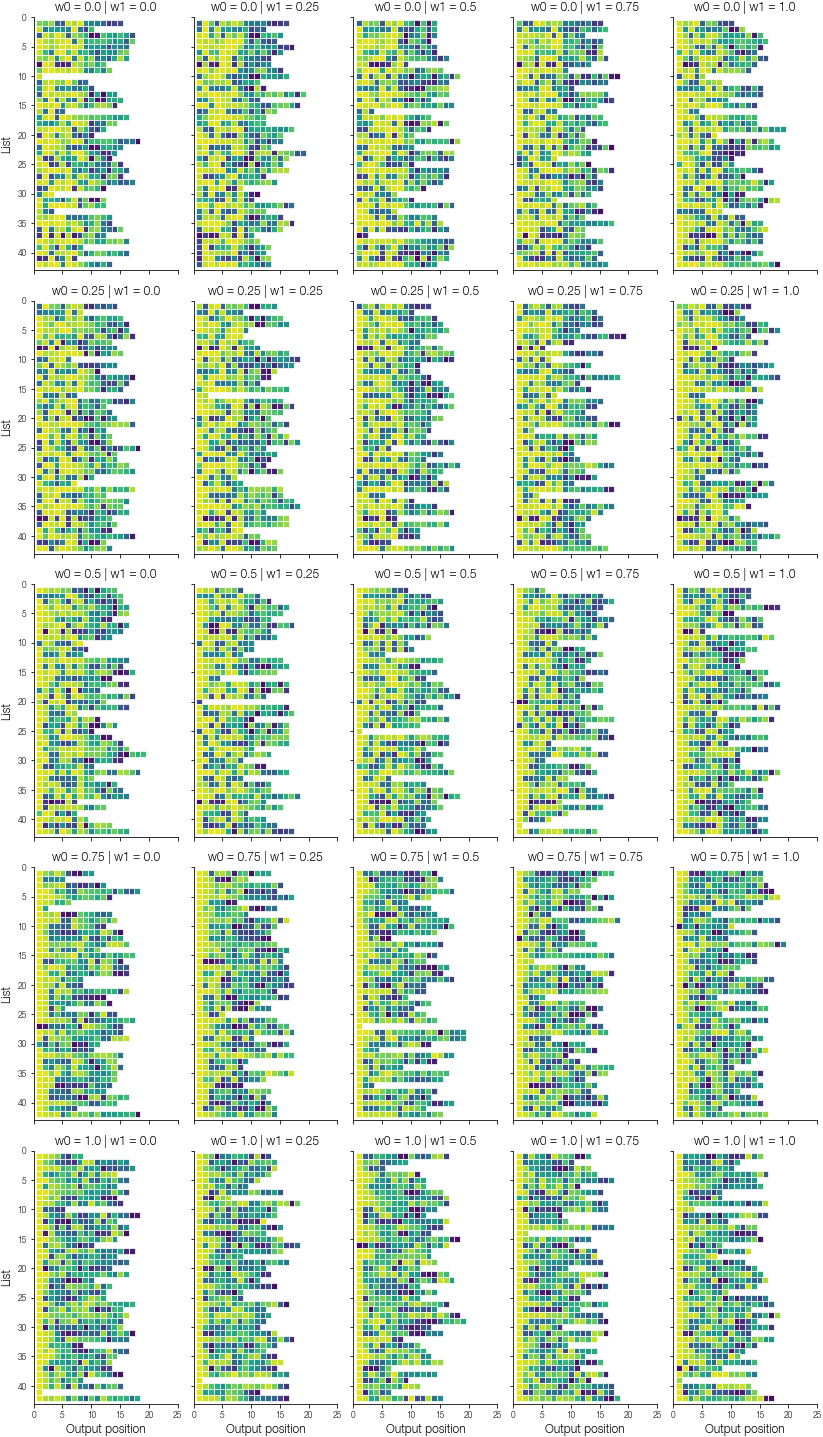

In [5]:
g = fr.plot_raster(fr.reset_list(sim1.reset_index()), 
                   row=param_names[0], col=param_names[1],
                   orientation='vertical', length=4);

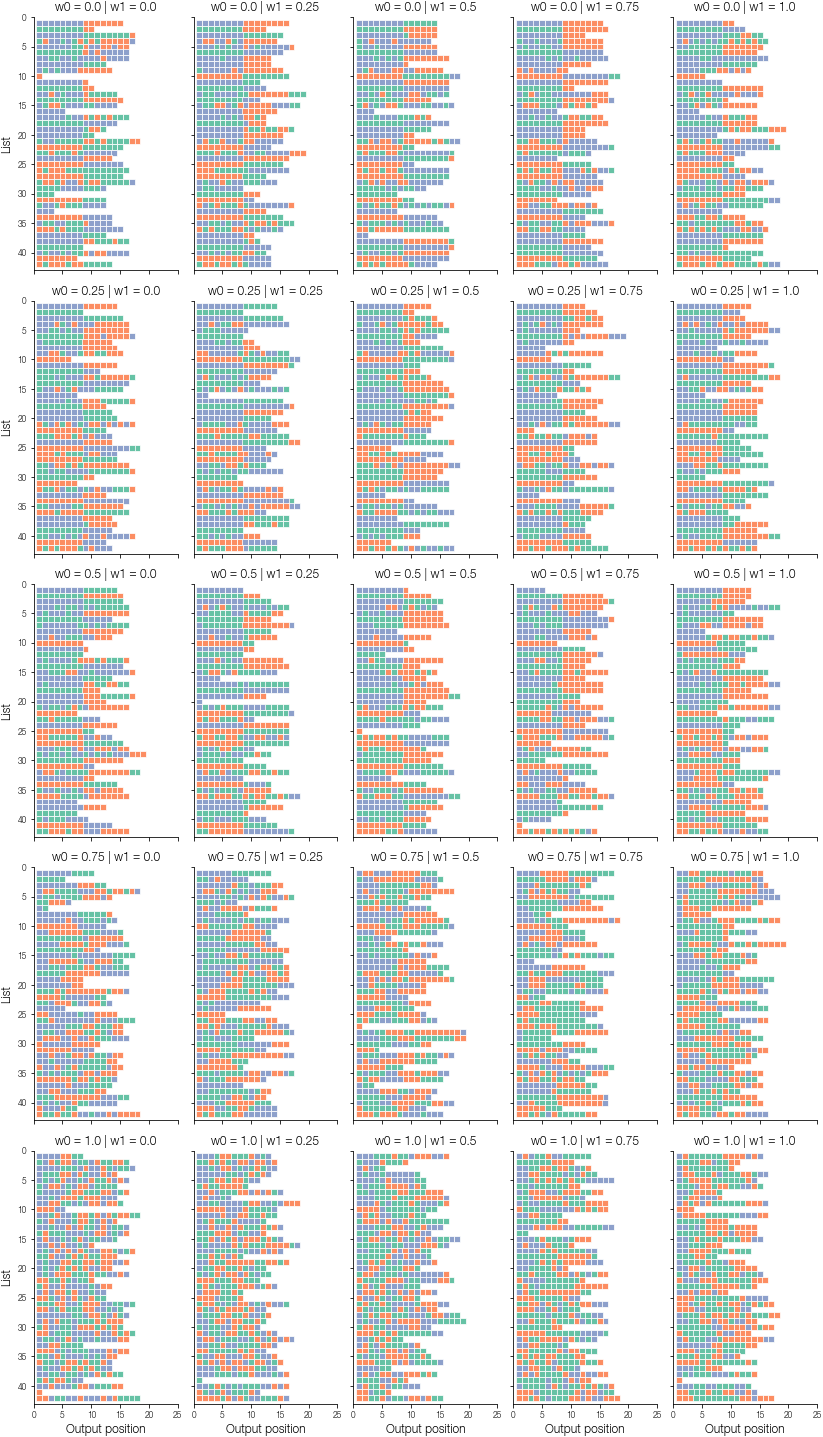

In [6]:
g = fr.plot_raster(fr.reset_list(sim1.reset_index()), hue='category',
                   palette=sns.color_palette('Set2', 3),
                   row=param_names[0], col=param_names[1],
                   orientation='vertical', length=4);

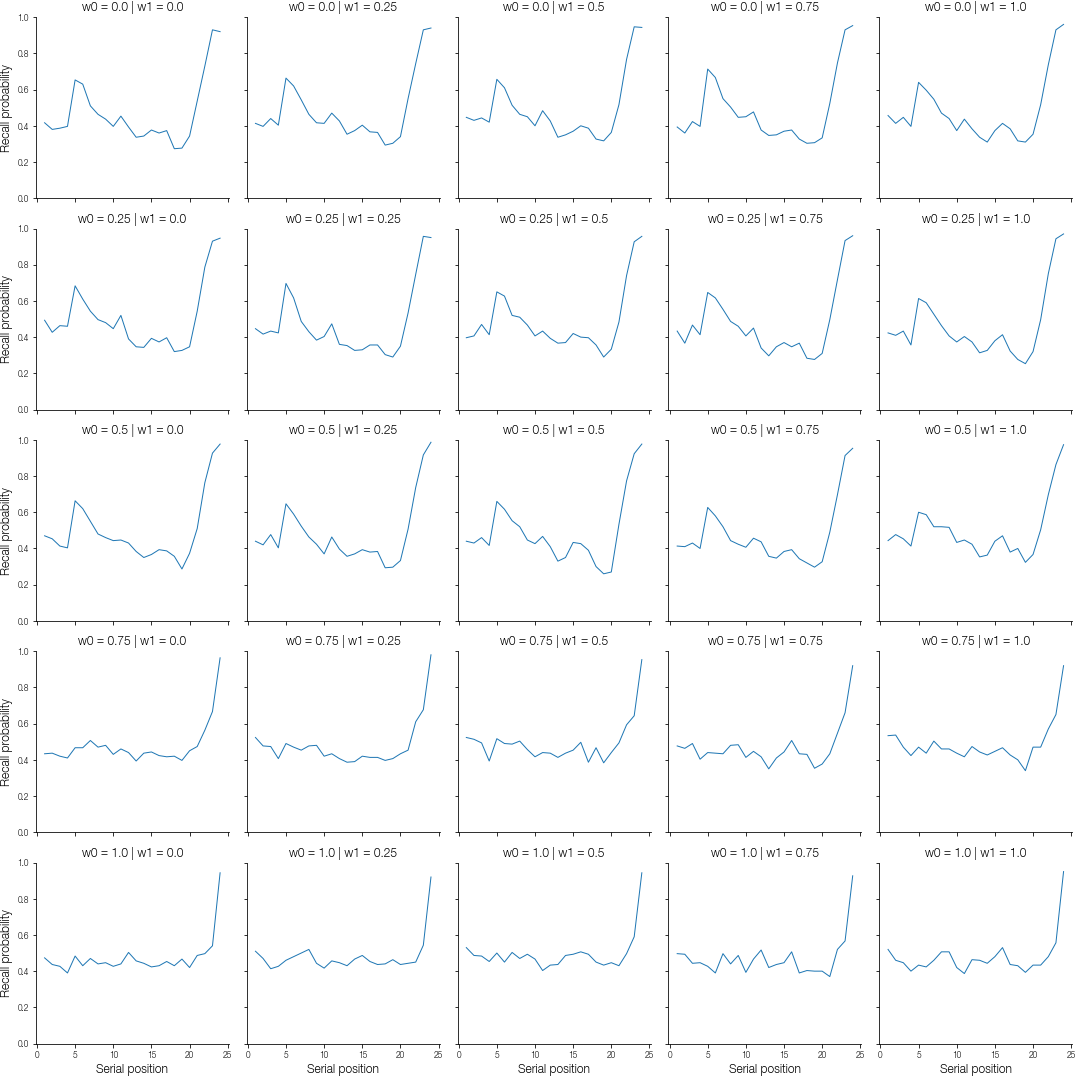

In [7]:
p = sim.groupby(level=[0, 1]).apply(fr.spc)
g = fr.plot_spc(p.reset_index(), row=param_names[0], col=param_names[1])

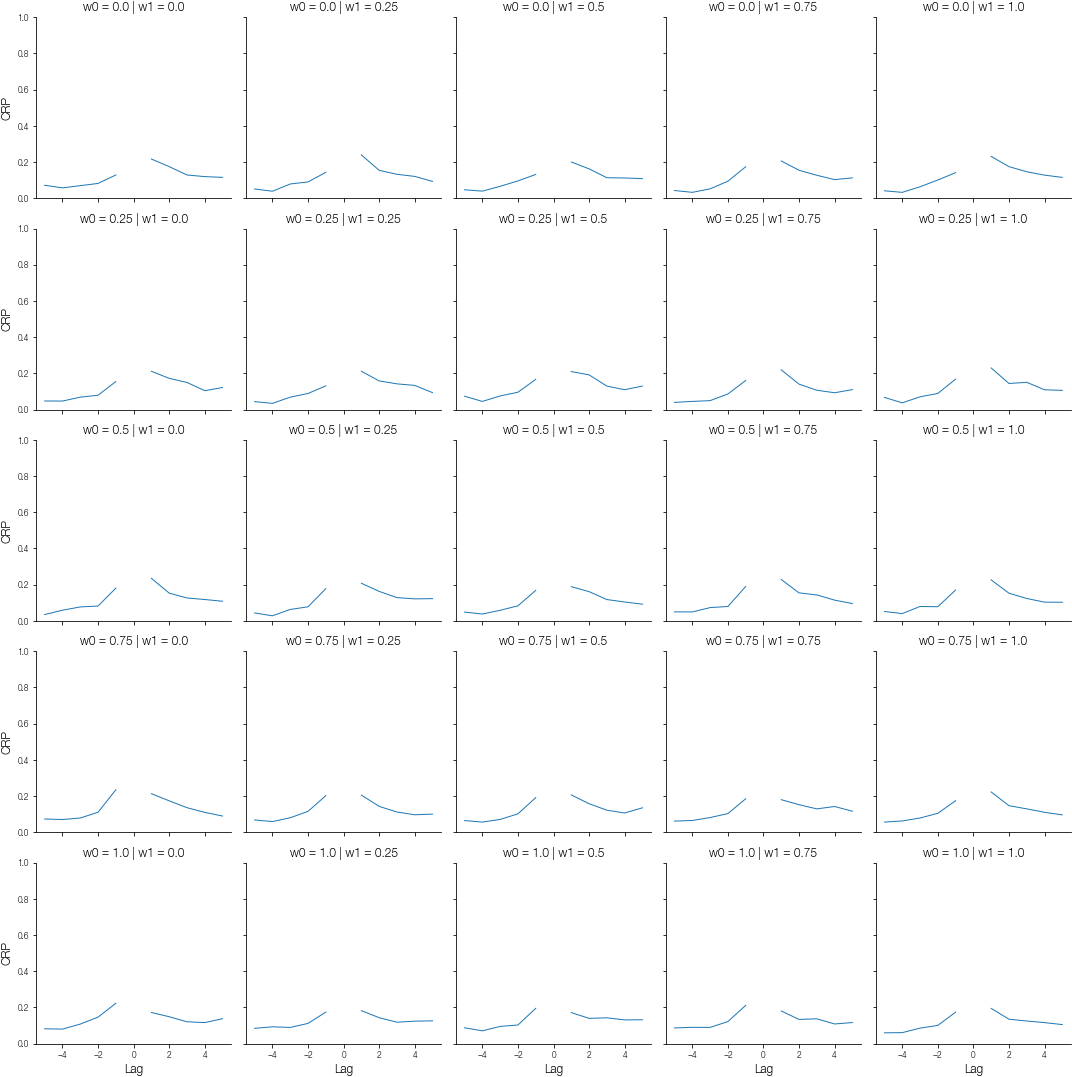

In [11]:
p = sim.groupby(level=[0, 1]).apply(fr.lag_crp, item_query='output > 3')
g = fr.plot_lag_crp(p.reset_index(), row=param_names[0], col=param_names[1])

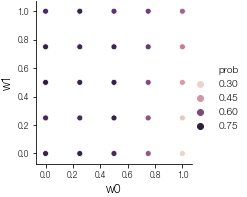

In [9]:
p = sim.groupby(level=[0, 1]).apply(fr.category_crp, category_key='category')
sns.relplot(kind='scatter', x='w0', y='w1', hue='prob', data=p.reset_index(),
            height=3);

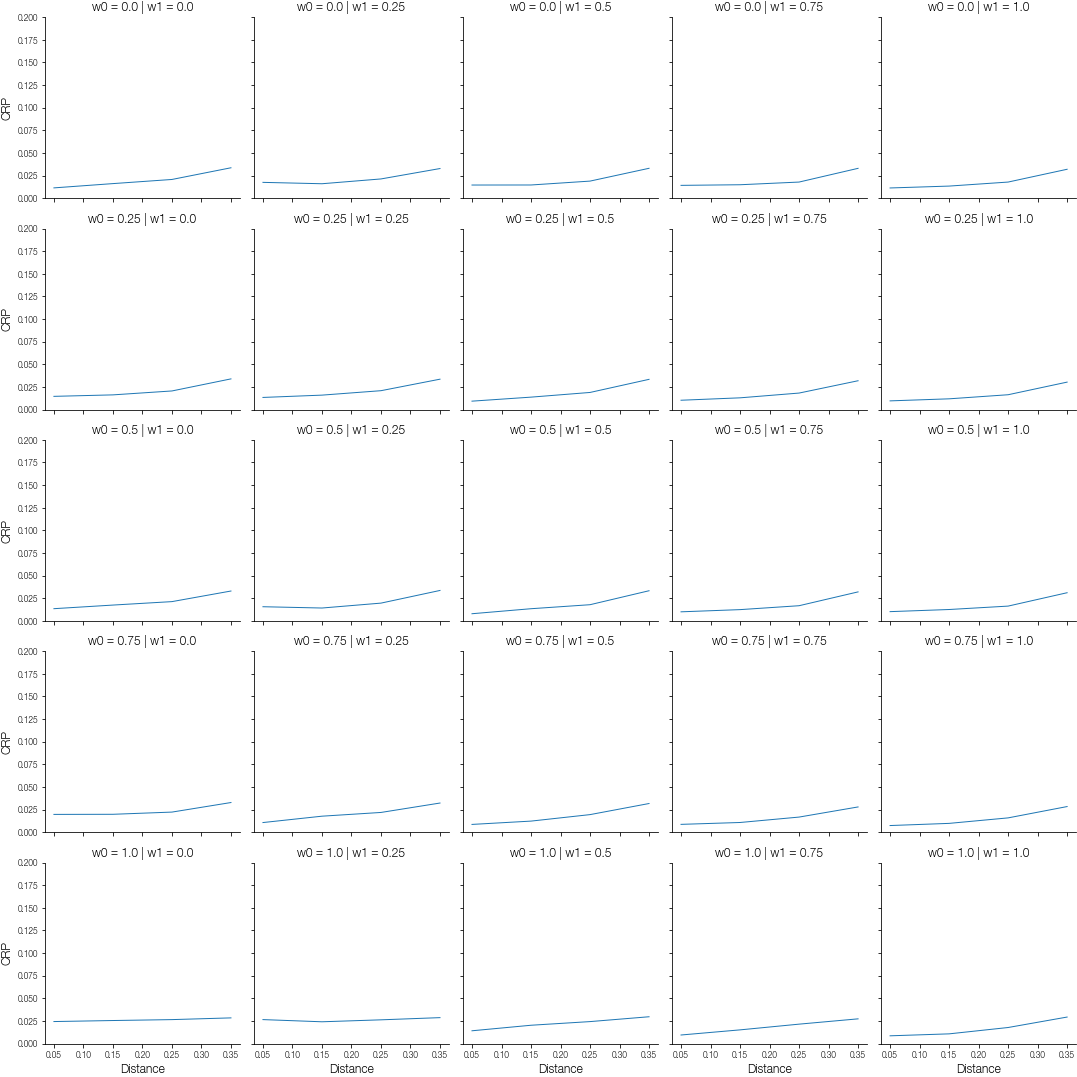

In [12]:
edges = np.linspace(0, .4, 5)
rsm = patterns['similarity']['use']
p = sim.groupby(level=[0, 1]).apply(fr.distance_crp, 'item_index', rsm, edges)
g = fr.plot_distance_crp(p.reset_index(), row=param_names[0], col=param_names[1])
g.set(ylim=[0, .2]);